2D Scenario

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
dt = 10  # time step, s
G = 6.67430e-11  # gravitational constant, m^3 kg^-1 s^-2
M_earth = 5.972e24  # mass of the Earth, kg
R_earth = 6371000  # radius of the Earth, m

# Initial Conditions
y_initial = 500000 + R_earth  # initial altitude, m
v_initial = -7800  # initial vertical velocity, m/s


In [52]:
## Will need further modifications

# State Vector [y, v]^T
x = np.array([y_initial, v_initial])

# Covariance Matrix
P = np.array([[1000**2, 0], [0, 100**2]])

# State Transition Model, currently assuming constant v
A = np.array([[1, dt], [0, 1]])

# Control Input (gravity only)
B = np.array([0.5 * dt**2, dt])
u = np.array([-G * M_earth / y_initial**2])

# Measurement Model
H = np.array([[1, 0]])
R = np.array([[500**2]])  # measurement noise covariance



In [53]:
# Kalman Filter Implementation
def kalman_filter(x, P):
    # Predict
    x_pred = A @ x + B * u  # state prediction, needs more modification in noise
    P_pred = A @ P @ A.T  # error covariance prediction

    if x_pred[0] <= R_earth:
        x_pred[0] = R_earth
        x_pred[1] = 0

    # Update
    z = np.random.normal(H @ x, 500)
    if z < R_earth:
        z = R_earth
    y = z - H @ x_pred
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x = x_pred + K @ y
    P = (np.eye(len(x)) - K @ H) @ P_pred

    return x, P, x_pred[0] <= R_earth



Landing detected at time: 370s


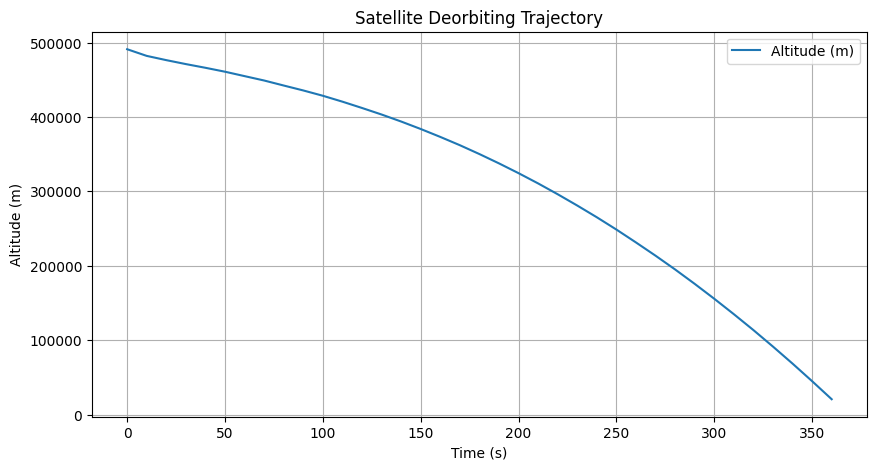

In [54]:
altitudes = []
times = np.arange(0, 2000, dt)

# Running the Kalman Filter
for time in times:
    x, P, landed = kalman_filter(x, P)
    if landed:
        print(f"Landing detected at time: {time}s")
        break
    altitudes.append(x[0] - R_earth)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(times[:len(altitudes)], altitudes, label='Altitude (m)')
plt.title('Satellite Deorbiting Trajectory')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.grid(True)
plt.legend()
plt.show()

LEO orbit:

Altitude - " It is normally at an altitude of less than 1000 km but could be as low as 160 km above Earth - which is low compared to other orbits, but still very far above Earth's surface."


Velocity - "Satellites in this orbit travel at a speed of around 7.8 km per second; at this speed, a satellite takes approximately 90 minutes to circle Earth, meaning the ISS travels around Earth about 16 times a day."

https://www.esa.int/ESA_Multimedia/Images/2020/03/Low_Earth_orbit



3D

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
dt = 0.1  # time step, seconds
G = 6.67430e-11  # gravitational constant, m^3 kg^-1 s^-2
M_earth = 5.972e24  # mass of the Earth, kg
R_earth = 6371000  # radius of the Earth, m

x_initial = np.array([R_earth + 400000, 0, 0])  # Initial position
v_initial = np.array([0, 7500, 100])  # Initial velocity

# State Vector [x, y, z, dx, dy, dz]^T
x = np.hstack((x_initial, v_initial))

# Covariance Matrix
P = np.eye(6) * 1000

# State Transition Model
A = np.eye(6)
A[0:3, 3:6] = np.eye(3) * dt

# Measurement Model
H = np.eye(6)
R = np.eye(6) * 500


In [56]:
def gravity(position):
    r = np.linalg.norm(position)
    return -G * M_earth / r**3 * position

def kalman_filter(x, P):
    # Gravity as control input
    u = gravity(x[:3])
    B = np.zeros((6, 3))
    B[3:, :] = np.eye(3) * dt

    # Predict
    x_pred = A @ x + B @ u  # state prediction
    P_pred = A @ P @ A.T  # error covariance

    if np.linalg.norm(x_pred[:3]) <= R_earth: # if result valid
        return x, P, True

    # Update
    z = H @ x + np.random.normal(0, 500, 6)  # simulate noisy measurements
    y = z - H @ x_pred  # measurement residual
    S = H @ P_pred @ H.T + R  # residual covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    x = x_pred + K @ y  # state update
    P = (np.eye(6) - K @ H) @ P_pred  # covariance update

    return x, P, False




Landing detected at time: 297.3s


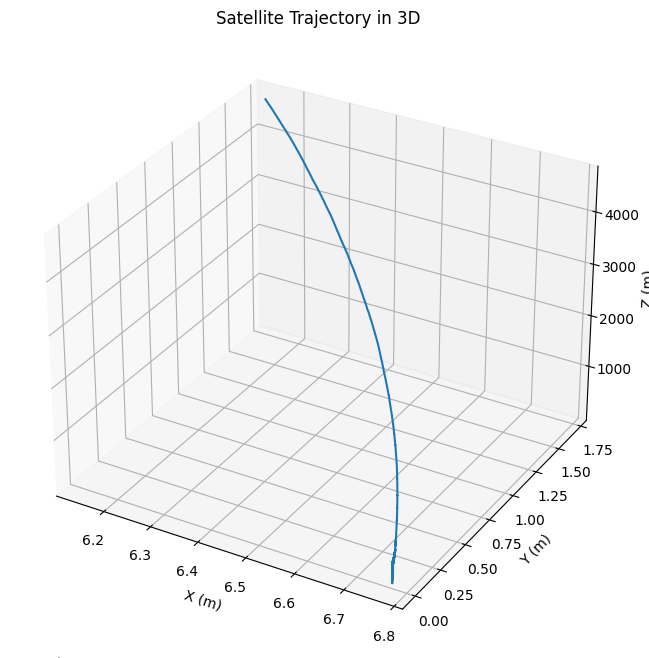

In [58]:
positions = []
times = np.arange(0, 2000, dt)

for time in times:
    if x[2] < 0:  # Check if the Z-coordinate is below 0
        x[2] = 0   # Reset Z-coordinate to 0
        break
    x, P, landed = kalman_filter(x, P)
    if landed:
        print(f"Landing detected at time: {time}s")
        break
    positions.append(x[:3])

positions = np.array(positions)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2])
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
plt.show()

This bit still got some issue for simulation as there are no actual data as reference or anything therefore just standard implimentation.